In [72]:
# Core data and processing libraries
import kagglehub
import pandas as pd
import numpy as np
import re
import os

# For train/val/test split
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

In [73]:
# Download and load all dataset splits
def load_data():
    path = kagglehub.dataset_download("csmalarkodi/liar-fake-news-dataset")
    print("Downloaded dataset files to:", path)

    # Load each split separately
    train_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/train.tsv', sep='\t', header=None)
    val_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/valid.tsv', sep='\t', header=None)
    test_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/test.tsv', sep='\t', header=None)

    # Combine for unified preprocessing
    df = pd.concat([train_df, val_df, test_df], ignore_index=True)

    # Drop index column if exists
    if 0 in df.columns:
        df = df.drop(0, axis=1)

    # Rename columns for clarity
    df.columns = [
        "label", "statement", "subject", "speaker", "speaker_job_title",
        "speaker_state", "speaker_party", "barely_true_counts", "false_counts",
        "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"
    ]

    return df, train_df.shape[0], val_df.shape[0]


In [89]:
# Clean and transform the dataset
def preprocess_data(df):
    # Lowercase column names
    df.columns = [c.lower() for c in df.columns]

    # Map original 6-class label to binary: fake (1), real (0)
    def map_label_to_binary(label_str):
        fake_labels = ["pants-fire", "false", "barely-true"]
        return 1 if label_str in fake_labels else 0

    df['label'] = df['label'].apply(map_label_to_binary)

    # Basic text cleaning
    def clean_text(text):
        if pd.isna(text):
            return ""
        text = text.lower()
        text = re.sub(r'http\S+|www\.\S+', '', text)
        text = re.sub(r'[^\w\s.,!?]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()       # normalize whitespace
        return text

    # Apply text cleaning to relevant columns
    text_columns = ['statement', 'subject', 'speaker', 'speaker_job_title', 'context']
    for col in text_columns:
        df[col] = df[col].fillna('').apply(clean_text)

    # Combine all text into one field for modeling
    df['combined_text'] = (
        df['statement'] + ' ' +
        df['subject'] + ' ' +
        df['speaker'] + ' ' +
        df['speaker_job_title'] + ' ' +
        df['context']
    )

    # Create credibility and fake ratio features
    df['total_checks'] = df[['barely_true_counts', 'false_counts',
                             'half_true_counts', 'mostly_true_counts',
                             'pants_on_fire_counts']].sum(axis=1)

    df['fake_ratio'] = (df['barely_true_counts'] + df['false_counts'] + df['pants_on_fire_counts']) / df['total_checks']
    df['fake_ratio'] = df['fake_ratio'].fillna(0)

    # Drop rows without labels
    df = df.dropna(subset=['label'])

    # Drop unused original columns
    df = df.drop(columns=[
        'statement', 'subject', 'speaker', 'speaker_job_title', 'context',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'total_checks',
        'speaker_state', 'speaker_party'
    ])

    return df


In [90]:
# Load and preprocess dataset
df, train_size, val_size = load_data()
df = preprocess_data(df)

Downloaded dataset files to: /kaggle/input/liar-fake-news-dataset


In [91]:
# Import NLP libraries
import spacy
from spacy.pipeline import EntityRuler

# Load spaCy model (disable parser and built-in NER for performance)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [92]:
# Set up the custom rule-based entity recognizer
def setup_entity_ruler(nlp):
    ruler = nlp.add_pipe(
        "entity_ruler",
        config={"overwrite_ents": True},
        name="custom_ruler",
        before="tok2vec"  # Place before any token vector encoding
    )

    # Define phrase patterns for semantic categories
    disappointed_phrases = [
        "disappointing", "let down", "failed to", "broken promise",
        "not living up", "fell short", "underwhelming", "not as expected",
        "worse than", "regrettable", "unfortunate", "dissatisfied"
    ]
    conspiracy_phrases = [
        "cover up", "hidden agenda", "conspiracy", "suppressed",
        "they don't want you to know", "mainstream media", "deep state",
        "false flag", "controlled opposition", "agenda"
    ]
    political_phrases = [
        "democrat", "republican", "senate", "congress", "election",
        "campaign", "legislation", "policy", "administration", "white house",
        "senator", "representative", "bill", "amendment", "vote"
    ]
    shocking_phrases = [
        "unbelievable", "shocking", "astonishing", "incredible",
        "hard to believe", "can't believe", "mind-blowing", "stunning",
        "outrageous", "appalling", "horrifying"
    ]
    propaganda_phrases = [
        "fake news", "hoax", "propaganda", "misinformation",
        "disinformation", "media lies", "narrative", "psychological operation",
        "brainwashing", "manufactured consent"
    ]

    # Convert phrases to pattern dictionaries
    patterns = []
    patterns += [{"label": "DISAPPOINTED", "pattern": text} for text in disappointed_phrases]
    patterns += [{"label": "CONSPIRACY", "pattern": text} for text in conspiracy_phrases]
    patterns += [{"label": "POLITICAL", "pattern": text} for text in political_phrases]
    patterns += [{"label": "SHOCKING", "pattern": text} for text in shocking_phrases]
    patterns += [{"label": "PROPAGANDA", "pattern": text} for text in propaganda_phrases]

    # Add custom patterns to the pipeline
    ruler.add_patterns(patterns)
    return nlp

# Apply custom entity ruler to spaCy pipeline
nlp = setup_entity_ruler(nlp)

In [93]:
# Add binary semantic flags and entity count features to dataframe
def add_custom_features(df, text_col="combined_text"):
    # Initialize new feature columns with zeros
    df["is_disappointed"] = 0
    df["is_conspiracy"] = 0
    df["is_political"] = 0
    df["is_shocking"] = 0
    df["is_propaganda"] = 0
    df["num_entities"] = 0

    # Analyze each sample
    for idx, row in df.iterrows():
        doc = nlp(row[text_col])
        labels_found = set(ent.label_ for ent in doc.ents)

        # Set binary flags if pattern detected
        if "DISAPPOINTED" in labels_found:
            df.at[idx, "is_disappointed"] = 1
        if "CONSPIRACY" in labels_found:
            df.at[idx, "is_conspiracy"] = 1
        if "POLITICAL" in labels_found:
            df.at[idx, "is_political"] = 1
        if "SHOCKING" in labels_found:
            df.at[idx, "is_shocking"] = 1
        if "PROPAGANDA" in labels_found:
            df.at[idx, "is_propaganda"] = 1

        # Count number of matched entities
        df.at[idx, "num_entities"] = len(doc.ents)

    return df

In [94]:
# Apply semantic and entity features
df = add_custom_features(df)

df['text_length'] = df['combined_text'].apply(len)  # character length
df['word_count'] = df['combined_text'].apply(lambda x: len(x.split()))  # word tokens
df['exclamation_count'] = df['combined_text'].apply(lambda x: x.count('!'))
df['question_count'] = df['combined_text'].apply(lambda x: x.count('?'))
df['quote_count'] = df['combined_text'].apply(lambda x: x.count('"') + x.count("'"))

In [95]:
print(df.head())

   label                                      combined_text  fake_ratio  \
0      1  says the annies list political group supports ...    1.000000   
1      0  when did the decline of coal start? it started...    0.000000   
2      0  hillary clinton agrees with john mccain by vot...    0.317125   
3      1  health care reform legislation is likely to ma...    0.897436   
4      0  the economic turnaround started at the end of ...    0.400000   

   is_disappointed  is_conspiracy  is_political  is_shocking  is_propaganda  \
0                0              0             1            0              0   
1                0              0             1            0              0   
2                0              0             0            0              0   
3                0              0             1            0              0   
4                0              0             0            0              0   

   num_entities  text_length  word_count  exclamation_count  question_coun

In [96]:
# Re-split combined dataframe back into original splits
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

In [98]:
# Output summary information
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")
print("Class distribution in train set:")
print(train_df['label'].value_counts(normalize=True))

Train size: 10240, Val size: 1284, Test size: 1267
Class distribution in train set:
label
0    0.561719
1    0.438281
Name: proportion, dtype: float64


In [17]:
# Core machine learning and deep learning libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Hugging Face Transformers library
from transformers import XLMRobertaTokenizer, XLMRobertaModel

# Optimization and metrics
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Preprocessing and utility libraries
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [18]:
# Automatically select GPU if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load tokenizer for XLM-RoBERTa base model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [19]:
# Compute class distribution to apply class weights
class_counts = Counter(train_df['label'])
total = sum(class_counts.values())
class_weights = torch.tensor([total / class_counts[0], total / class_counts[1]], dtype=torch.float32).to(device)

In [20]:
# List of all engineered numeric features
numeric_columns = [
    'fake_ratio', 'text_length', 'word_count',
    'exclamation_count', 'question_count', 'quote_count',
    'is_disappointed', 'is_conspiracy', 'is_political',
    'is_shocking', 'is_propaganda', 'num_entities'
]

# Apply standard scaling to numeric features
scaler = StandardScaler()
train_numeric = scaler.fit_transform(train_df[numeric_columns])
val_numeric = scaler.transform(val_df[numeric_columns])
test_numeric = scaler.transform(test_df[numeric_columns])

In [21]:
class EnhancedFakeNewsDataset(Dataset):
    def __init__(self, df, numeric_features, tokenizer, max_len=256):
        self.texts = list(df['combined_text'])
        self.labels = list(df['label'])
        self.numeric_features = numeric_features
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        numeric = torch.tensor(self.numeric_features[idx], dtype=torch.float32)
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'numeric_features': numeric,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        CE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss
        return F_loss.mean()

In [23]:
class EnhancedRobertaClassifier(nn.Module):
    def __init__(self, n_features=12, dropout_rate=0.3):
        super(EnhancedRobertaClassifier, self).__init__()

        # Load base XLM-RoBERTa model
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')

        # Freeze most layers, only fine-tune last 4 transformer layers
        for param in self.roberta.parameters():
            param.requires_grad = False
        for layer in self.roberta.encoder.layer[-4:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Text processing branch
        self.text_fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.roberta.config.hidden_size, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256)
        )
        self.text_residual = nn.Linear(self.roberta.config.hidden_size, 256)

        # Numeric feature processing branch
        self.numeric_fc = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.LayerNorm(64)
        )

        # Fusion and final classification
        self.combined_fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 + 64, 128),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 2)
        )

    def forward(self, input_ids, attention_mask, numeric_features):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)

        residual = self.text_residual(pooled_output)
        text_features = self.text_fc(pooled_output) + residual

        numeric_features = self.numeric_fc(numeric_features)

        combined = torch.cat((text_features, numeric_features), dim=1)
        logits = self.combined_fc(combined)
        return logits

In [27]:
def train_enhanced_model(train_loader, val_loader, test_loader, epochs, learning_rate):
    model = EnhancedRobertaClassifier().to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    loss_fn = FocalLoss().to(device)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_correct, train_total = 0, 0
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numeric_features = batch['numeric_features'].to(device)
            labels = batch['labels'].to(device)
o
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(input_ids, attention_mask, numeric_features)
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(logits.detach(), dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            total_train_loss += loss.item()

        train_acc = train_correct / train_total
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                numeric_features = batch['numeric_features'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask, numeric_features)
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"\nEpoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_enhanced_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    # Plot loss and accuracy curves
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    return model


Training enhanced XLM-RoBERTa model...


Epoch 1/10: 100%|██████████| 640/640 [00:23<00:00, 27.24it/s]



Epoch 1: Train Loss: 0.1491 | Train Acc: 0.6804 | Val Loss: 0.1309 | Val Acc: 0.7360


Epoch 2/10: 100%|██████████| 640/640 [00:23<00:00, 26.87it/s]



Epoch 2: Train Loss: 0.1341 | Train Acc: 0.7317 | Val Loss: 0.1278 | Val Acc: 0.7445


Epoch 3/10: 100%|██████████| 640/640 [00:23<00:00, 27.09it/s]



Epoch 3: Train Loss: 0.1290 | Train Acc: 0.7496 | Val Loss: 0.1251 | Val Acc: 0.7516


Epoch 4/10: 100%|██████████| 640/640 [00:23<00:00, 27.45it/s]



Epoch 4: Train Loss: 0.1256 | Train Acc: 0.7571 | Val Loss: 0.1257 | Val Acc: 0.7438


Epoch 5/10: 100%|██████████| 640/640 [00:23<00:00, 27.52it/s]



Epoch 5: Train Loss: 0.1194 | Train Acc: 0.7749 | Val Loss: 0.1257 | Val Acc: 0.7539


Epoch 6/10: 100%|██████████| 640/640 [00:23<00:00, 26.70it/s]



Epoch 6: Train Loss: 0.1077 | Train Acc: 0.8107 | Val Loss: 0.1363 | Val Acc: 0.7430


Epoch 7/10: 100%|██████████| 640/640 [00:23<00:00, 27.51it/s]



Epoch 7: Train Loss: 0.0905 | Train Acc: 0.8511 | Val Loss: 0.1573 | Val Acc: 0.7298


Epoch 8/10: 100%|██████████| 640/640 [00:23<00:00, 27.19it/s]



Epoch 8: Train Loss: 0.0806 | Train Acc: 0.8740 | Val Loss: 0.1939 | Val Acc: 0.7173
Early stopping.


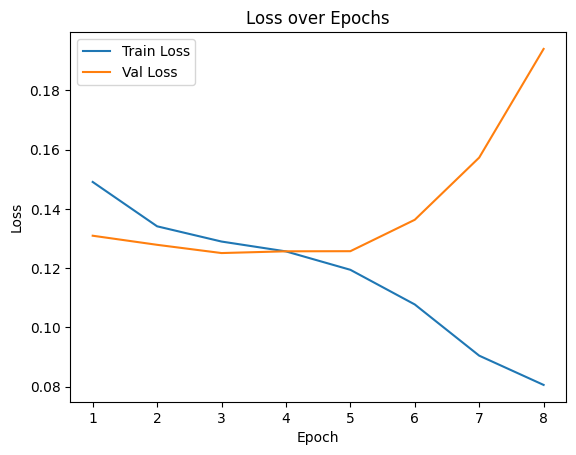

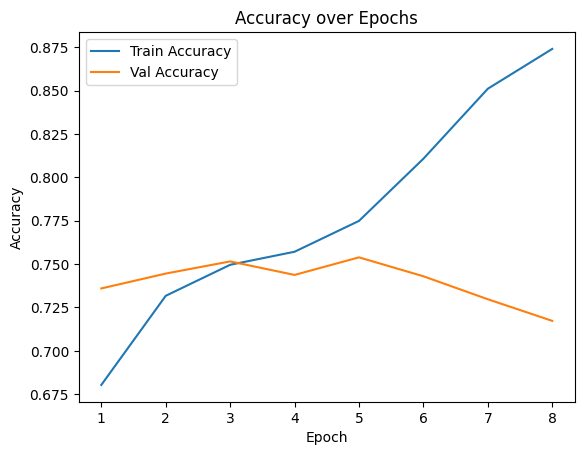

In [42]:
# Instantiate datasets
train_ds = EnhancedFakeNewsDataset(train_df, train_numeric, tokenizer)
val_ds = EnhancedFakeNewsDataset(val_df, val_numeric, tokenizer)
test_ds = EnhancedFakeNewsDataset(test_df, test_numeric, tokenizer)

# Data loaders for efficient batching
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

# Train the model
print("\nTraining enhanced XLM-RoBERTa model...")
model = train_enhanced_model(
    train_loader,
    val_loader,
    test_loader,
    epochs=10,
    learning_rate=2e-5
)

In [29]:
def calculate_final_metrics(true_labels, predictions, probs):
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, probs)

    print("\n=== Final Test Set Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

In [43]:
# Final evaluation on test set
model.load_state_dict(torch.load('best_enhanced_model.pt'))
model.eval()
test_preds, test_true, test_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      numeric_features = batch['numeric_features'].to(device)
      labels = batch['labels'].to(device)

      logits = model(input_ids, attention_mask, numeric_features)
      probs = torch.softmax(logits, dim=1)
      preds = torch.argmax(probs, dim=1)

      test_preds.extend(preds.cpu().numpy())
      test_true.extend(labels.cpu().numpy())
      test_probs.extend(probs[:, 1].cpu().numpy())
calculate_final_metrics(test_true, test_preds, test_probs)


=== Final Test Set Metrics ===
Accuracy: 0.7443
Precision: 0.6880
Recall: 0.7577
F1 Score: 0.7212
AUC Score: 0.8305


In [35]:
# Preprocessing and modeling libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Benchmark classifiers
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [36]:
# Define column types
text_features = 'combined_text'  # single text column
numeric_features = [
    'fake_ratio', 'text_length', 'word_count',
    'exclamation_count', 'question_count', 'quote_count',
    'is_disappointed', 'is_conspiracy', 'is_political',
    'is_shocking', 'is_propaganda', 'num_entities'
]

In [37]:
# TF-IDF transformation for text features
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=5000,
        sublinear_tf=True
    ))
])

# Standardization for numerical features
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Column-wise preprocessing
preprocessor = ColumnTransformer([
    ('text', text_transformer, text_features),
    ('num', numeric_transformer, numeric_features)
])

In [38]:
# Define a dictionary of benchmark models with tuned parameters
models = {
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', use_label_encoder=False,
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000, C=0.5, penalty='l2', solver='liblinear', random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5, random_state=42
    ),
    "SVM": SVC(
        C=1.0, kernel='rbf', probability=True, random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(100, 50), activation='relu',
        solver='adam', early_stopping=True, random_state=42
    )
}

In [39]:
# Set feature matrix and target vector
X_train = train_df
y_train = train_df['label']
X_test = test_df
y_test = test_df['label']

In [40]:
# List to hold results for each classifier
results = []

# Iterate over each model, train and evaluate
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    # Predict class and probability
    y_test_pred = pipeline.predict(X_test)
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    # Save results
    results.append({
        "Model": name,
        "Test Accuracy": round(test_acc, 4),
        "Test Precision": round(test_prec, 4),
        "Test Recall": round(test_rec, 4),
        "Test F1": round(test_f1, 4),
        "Test ROC-AUC": round(test_auc, 4)
    })

In [41]:
# Create a DataFrame of the collected results
df_results = pd.DataFrame(results)

# Display formatted results
print("\n=== Benchmark Models – Test Set Performance ===")
print(df_results.to_string(index=False))


=== Benchmark Models – Test Set Performance ===
             Model  Test Accuracy  Test Precision  Test Recall  Test F1  Test ROC-AUC
           XGBoost         0.7451          0.7386       0.6438   0.6879        0.8186
LogisticRegression         0.7459          0.7362       0.6510   0.6910        0.8281
      RandomForest         0.6093          0.7636       0.1519   0.2534        0.7665
               SVM         0.7459          0.7584       0.6130   0.6780        0.8188
  GradientBoosting         0.7482          0.7448       0.6438   0.6906        0.8217
               MLP         0.7522          0.7357       0.6745   0.7038        0.8266
